# Plot temperature diagnostics

In [1]:
import os
import matplotlib.pyplot as plt
import json
from glob import glob
import numpy as np
from pathlib import Path
import h5py
from tqdm import tqdm
import scipy.stats
import torch
import seaborn as sns

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

sns.set(style="white", context="paper", font_scale=1.5)

/vol/bitbucket/yn621/envs/bnn_prior/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mean_stderr_temp(metrics, mask, temp_group):
    temps = metrics[temp_group]["all"][mask]
    mean = np.mean(temps)
    stderr = np.std(temps)
    return mean, stderr

In [3]:
def weighted_mean_stderr_temp(metrics, mask, sizes, temp_group):
    keys = list(metrics[temp_group].keys())
    keys.remove("all")
    temps = np.stack([metrics[temp_group][k][mask] for k in keys], axis=1)
    weights = np.array([sizes[k] for k in keys])
    mean, stderr = plot.weighted_var_se(weights, temps)
    return mean, stderr

In [4]:
# choose your experiment name here
exp_name = "exp_cifar10_augmented_depth20_width3_lr0.3_warmup45_cycles60_scale2"

selected_priors = ["gaussian"] # ["gaussian", "convcorrnormal", "laplace", "student-t"]

skip = 10

# we again assume you saved it in ../results/, otherwise change that here
metrics_files = glob(f"/data2/users/yn621/bnn_models/run1/{exp_name}/*/metrics.h5")

colors = sns.color_palette("cubehelix", n_colors=7)
temps = [0.001, 0.01, 0.1, 1]

cmap = {temp: col for temp, col in zip(temps, colors)}

means_est = {str(temp) : [] for temp in temps}
stderrs_est = {str(temp) : [] for temp in temps}
means_conf = {str(temp) : [] for temp in temps}
stderrs_conf = {str(temp) : [] for temp in temps}

for metrics_file in tqdm(metrics_files):

    log_dir = Path(os.path.dirname(metrics_file))

    with open(log_dir/"config.json", "r") as f:
        config = json.load(f)

    if config["weight_prior"] not in selected_priors:
        continue

    device = torch.device("cpu")  # can be CUDA instead
    data = exp_utils.get_data(config["data"], device)
    model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                                **{k: v for k, v in config.items() if k in set((
                                    "model",
                                    "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                                    "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                                    "weight_prior_params", "bias_prior_params"))})

    sizes = plot.get_sizes(model)

    metrics = h5py.File(metrics_file, "r", swmr=True)

    mask = np.where(metrics["lr"][:] == np.nanmin(metrics["lr"][:]))
    mask = mask[::skip]

    mean, stderr = weighted_mean_stderr_temp(metrics, mask, sizes, "est_temperature")
    means_est[str(config["temperature"])].extend(mean)
    stderrs_est[str(config["temperature"])].extend(stderr)

    mean, stderr = weighted_mean_stderr_temp(metrics, mask, sizes, "est_config_temp")
    means_conf[str(config["temperature"])].extend(mean)
    stderrs_conf[str(config["temperature"])].extend(stderr)


100%|██████████| 12/12 [06:34<00:00, 32.87s/it]


/vol/bitbucket/yn621/envs/bnn_prior/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


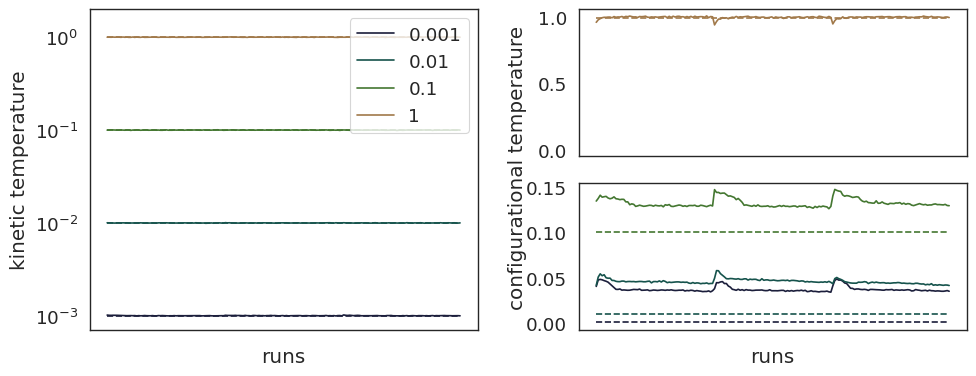

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4))

gs = axes[0,0].get_gridspec()
axes[0,0].remove()
axes[1,0].remove()

axkin = fig.add_subplot(gs[:, 0])
axconf_top = axes[0,1]
axconf_bot = axes[1,1]


for temp in temps:
    means = np.array(means_est[str(temp)])
    stderrs = np.array(stderrs_est[str(temp)])
    axkin.plot(np.arange(len(means)), [temp]*len(means), linestyle="--", color=cmap[temp])
    sns.lineplot(x=np.arange(len(means)), y=means, label=temp, color=cmap[temp], ax=axkin)
    axkin.fill_between(means-stderrs, means+stderrs)

for temp in temps[:3]:
    means = np.array(means_conf[str(temp)])
    stderrs = np.array(stderrs_conf[str(temp)])
    axconf_bot.plot(np.arange(len(means)), [temp]*len(means), linestyle="--", color=cmap[temp])
    sns.lineplot(x=np.arange(len(means)), y=means, color=cmap[temp], ax=axconf_bot)
    axconf_bot.fill_between(means-stderrs, means+stderrs)

for temp in temps[3:]:
    means = np.array(means_conf[str(temp)])
    stderrs = np.array(stderrs_conf[str(temp)])
    axconf_top.plot(np.arange(len(means)), [temp]*len(means), linestyle="--", color=cmap[temp])
    sns.lineplot(x=np.arange(len(means)), y=means, color=cmap[temp], ax=axconf_top)
    axconf_top.fill_between(means-stderrs, means+stderrs)


axkin.set_yscale("log")
axkin.legend(loc="upper right")
axkin.set_ylabel("kinetic temperature")
axkin.set_xlabel("runs")
axkin.set_ylim(0,2)
axkin.set_xticklabels([])

axconf_bot.set_xlabel("runs")
axconf_bot.set_xticklabels([])

axconf_top.set_xticklabels([])

fig.text(0.52, 0.55, 'configurational temperature', va='center', rotation='vertical')

fig.tight_layout(w_pad=3.)

fig.savefig(f"../figures/{exp_name}_temperature_diagnostics.pdf")